# AT&T Spam Detector Project

## IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from tensorflow.keras.preprocessing.text import Tokenizer
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalAveragePooling1D, GRU, SimpleRNN, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from wordcloud import WordCloud

import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorboard.plugins.hparams import api as hp
import warnings
warnings.filterwarnings("ignore")

2024-07-24 13:04:00.032149: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## IMPORT DATA

In [2]:
df = pd.read_csv('spam.csv', encoding='latin1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


## EXPLORE DATA

In [3]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


There are 3 useless columns that we should remove.

In [4]:
#Replacing Nan by empty values and Concatenate all columns into one
df['Unnamed: 2'] = df['Unnamed: 2'].fillna("")
df['Unnamed: 3'] = df['Unnamed: 3'].fillna("")
df['Unnamed: 4'] = df['Unnamed: 4'].fillna("")
df['v2']=pd.concat([df['v2'],df['Unnamed: 2'],df['Unnamed: 3'],df['Unnamed: 4']], ignore_index=True)

#Keeping just the two first columns
df = df[['v1','v2']]

df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Let's have a look at some of the lines to see their content

In [5]:
df['v2'][100]

'Okay name ur price as long as its legal! Wen can I pick them up? Y u ave x ams xx'

In [6]:
df['v2'][55]

'Do you know what Mallika Sherawat did yesterday? Find out now @  &lt;URL&gt;'

In [7]:
df['v2'][412]

"Okies... I'll go yan jiu too... We can skip ard oso, go cine den go mrt one, blah blah blah... "

Let's have a look now at the distribution of spams and hams in our first column

In [8]:
#Looking for what spams look like
df.loc[df['v1']=='spam',:]

,v1,v2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [9]:
df['v1'].value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

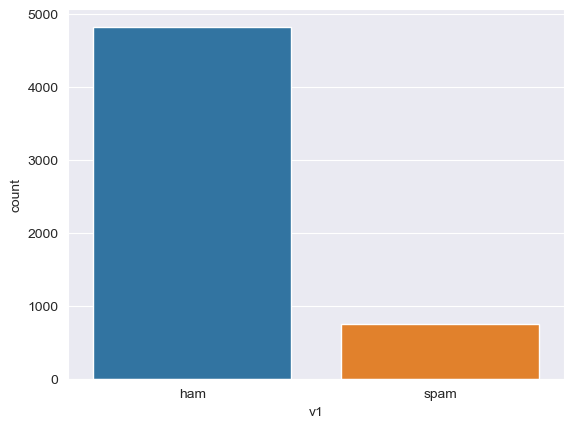

In [10]:
sns.countplot(data=df,x='v1')
plt.show()

In [11]:
print("Percentage of spams in our data is {}%".format(round(df.v1.value_counts()[1]/len(df.v1)*100, 2)))


Percentage of spams in our data is 13.41%


The dataset is imbalanced, yet it remains a large enough sample to get interesting results.

## PREPROCESSING

### Spacy

In [12]:
# Using spacy library :
nlp = spacy.load('en_core_web_sm')

In [13]:
# let's rename columns first :
df.rename(columns={"v1": "Target", "v2": "Text"}, inplace=True)

In [14]:
# Remove all non alphanumeric characters except whitespaces :
df["text_clean"] = df["Text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))

# removing double spaces and spaces at the beginning and end of strings :
df["text_clean"] = df["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())

# removing stop words and replacing every word with their lemma :
df["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [15]:
# Labeling the targert column :
df['Target_value'] = df['Target'].map({'ham':0,'spam':1})

In [16]:
df.head()

,Target,Text,text_clean,Target_value
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,1
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,0


### WordCloud

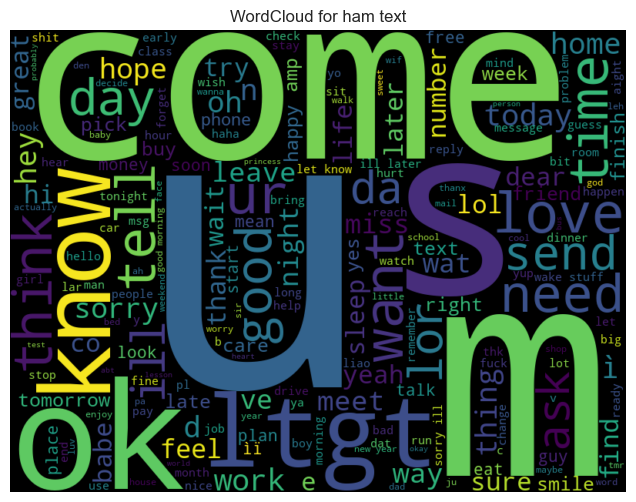

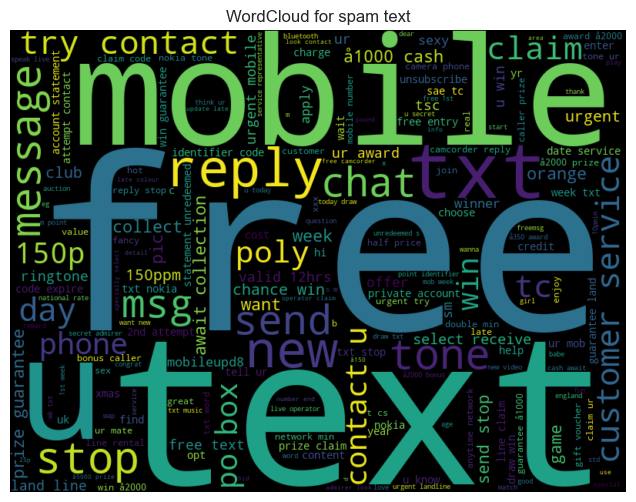

In [17]:
# Generate and display word clouds for each target category
for target in df['Target'].unique():
    words = ' '.join(df[df['Target'] == target]['text_clean'])
    wordcloud = WordCloud(width=800, height=600).generate(words)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"WordCloud for {target} text")
    plt.axis('off')
    plt.show()

### Tokenization

In [18]:
# Tokenize using TensorFlow's Tokenizer
max_words = 3000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token="out_of_vocab")
tokenizer.fit_on_texts(df['text_clean'])
df["text_tokenized"] = tokenizer.texts_to_sequences(df['text_clean'])

df.head()

,Target,Text,text_clean,Target_value,text_tokenized
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,0,"[1, 230, 446, 462, 941, 36, 52, 204, 942, 79, ..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,0,"[10, 195, 463, 289, 2, 1452]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,1,"[13, 299, 4, 532, 663, 34, 1453, 850, 422, 145..."
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,0,"[2, 125, 150, 2353, 2, 85]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,0,"[708, 23, 664, 129]"


### Padding

In [19]:
# Apply padding to the tokenized text :
text_padded = tf.keras.preprocessing.sequence.pad_sequences(df["text_tokenized"], padding="post")

text_padded

array([[   1,  230,  446, ...,    0,    0,    0],
       [  10,  195,  463, ...,    0,    0,    0],
       [  13,  299,    4, ...,    0,    0,    0],
       ...,
       [   1,  936,    1, ...,    0,    0,    0],
       [ 113,    1, 1589, ...,    0,    0,    0],
       [2074,  319,    0, ...,    0,    0,    0]], dtype=int32)

In [20]:
text_padded.shape

(5572, 72)

The length of the texts in our dataset is now 72

### Train_Test Split

In [21]:
# Splitting into train and val sets :
X_train, X_val, y_train, y_val = train_test_split(text_padded,df['Target_value'], test_size=0.3)

In [22]:
# Convert to TensorFlow Dataset
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Shuffle and batch the datasets
batch_size = 64
train_batch = train.shuffle(buffer_size=len(train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_batch = val.shuffle(buffer_size=len(val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [23]:
# Let's take a look at a batch
for text, value in train_batch.take(1):
  print(text, value)

tf.Tensor(
[[   1    2 1089 ...    0    0    0]
 [   1  203    1 ...    0    0    0]
 [  47   51  761 ...    0    0    0]
 ...
 [ 445    0    0 ...    0    0    0]
 [  54  206  205 ...    0    0    0]
 [   2   72   19 ...    0    0    0]], shape=(64, 72), dtype=int32) tf.Tensor(
[0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(64,), dtype=int64)


In [24]:
text.shape

TensorShape([64, 72])

### Training model

#### First model : Simple model from scratch :


In [25]:
vocab_size = tokenizer.num_words
embedding_dim= 16
model = Sequential([
                  Embedding(vocab_size+1, embedding_dim,input_shape=[text.shape[1],], name="embedding"), # +1 for the padding value 0
                  GlobalAveragePooling1D(),
                  Dense(64, activation='relu'),
                  Dense(32, activation='relu'),
                  Dense(8, activation='relu'),
                  Dense(1, activation="sigmoid")
]);

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 16)            48016     
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                        

In [27]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
#Fitting the model
history = model.fit(train_batch,
                    epochs=50,
                    validation_data=val_batch)

Epoch 1/50
61/61 [==============================] - 2s 6ms/step - loss: 0.5771 - accuracy: 0.8674 - val_loss: 0.4010 - val_accuracy: 0.8624
Epoch 2/50
61/61 [==============================] - 0s 3ms/step - loss: 0.3636 - accuracy: 0.8674 - val_loss: 0.3616 - val_accuracy: 0.8624
Epoch 3/50
61/61 [==============================] - 0s 3ms/step - loss: 0.3410 - accuracy: 0.8674 - val_loss: 0.3298 - val_accuracy: 0.8624
Epoch 4/50
61/61 [==============================] - 0s 3ms/step - loss: 0.2791 - accuracy: 0.8703 - val_loss: 0.2192 - val_accuracy: 0.8858
Epoch 5/50
61/61 [==============================] - 0s 3ms/step - loss: 0.1359 - accuracy: 0.9515 - val_loss: 0.1028 - val_accuracy: 0.9671
Epoch 6/50
61/61 [==============================] - 0s 3ms/step - loss: 0.0697 - accuracy: 0.9800 - val_loss: 0.0752 - val_accuracy: 0.9719
Epoch 7/50
61/61 [==============================] - 0s 3ms/step - loss: 0.0478 - accuracy: 0.9854 - val_loss: 0.0700 - val_accuracy: 0.9749
Epoch 8/50
61/61 [==

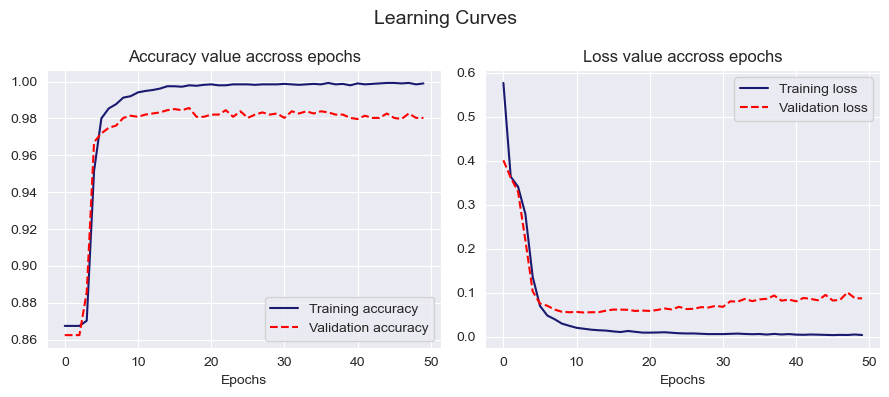

In [29]:
#Subplot
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Plotting accuracy on the first subplot
ax[0].plot(history.history["accuracy"], color="midnightblue",label="Training accuracy")
ax[0].plot(history.history["val_accuracy"], color="r",ls='--',label="Validation accuracy")
ax[0].set_title('Accuracy value accross epochs')
ax[0].legend()

# Plotting loss on the second subplot
ax[1].plot(history.history["loss"], color="midnightblue",label="Training loss")
ax[1].plot(history.history["val_loss"], ls='--', color="r",label="Validation loss")
ax[1].set_title("Loss value accross epochs")
ax[1].legend()

#Labelling axis x
for ax in ax:
    ax.set(xlabel='Epochs')

#Suptitle
fig.suptitle('Learning Curves', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [30]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_batch)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

27/27 [==============================] - 0s 2ms/step - loss: 0.0868 - accuracy: 0.9803
Validation Loss: 0.08675319701433182
Validation Accuracy: 0.9802631735801697


The model gives decent results. Validation accuracy remains more or less stable after 10 epochs but the validation loss seems to increase a bit.

In [31]:
# saving the model :
model.save("spam_detector_model.h5")

#### Second model : LSTM :

In [32]:
# Defining the model :
model_lstm = Sequential([
                  Embedding(vocab_size+1, embedding_dim, input_shape=[text.shape[1],], name="embedding"),
                  LSTM(units=64, return_sequences=True),
                  LSTM(units=32, return_sequences=False),
                  Dense(16, activation='relu'),
                  Dense(1, activation="sigmoid")
]);

In [33]:
# Compile the model

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
# Training the model :
history_lstm=model_lstm.fit(train_batch,
                    epochs=50,
                    validation_data=val_batch)

Epoch 1/50
61/61 [==============================] - 12s 98ms/step - loss: 0.4434 - accuracy: 0.8556 - val_loss: 0.4039 - val_accuracy: 0.8624
Epoch 2/50
61/61 [==============================] - 4s 64ms/step - loss: 0.3922 - accuracy: 0.8674 - val_loss: 0.4013 - val_accuracy: 0.8624
Epoch 3/50
61/61 [==============================] - 4s 66ms/step - loss: 0.3918 - accuracy: 0.8674 - val_loss: 0.4008 - val_accuracy: 0.8624
Epoch 4/50
61/61 [==============================] - 4s 60ms/step - loss: 0.3945 - accuracy: 0.8674 - val_loss: 0.4012 - val_accuracy: 0.8624
Epoch 5/50
61/61 [==============================] - 4s 70ms/step - loss: 0.3924 - accuracy: 0.8674 - val_loss: 0.4044 - val_accuracy: 0.8624
Epoch 6/50
61/61 [==============================] - 5s 78ms/step - loss: 0.3923 - accuracy: 0.8674 - val_loss: 0.4010 - val_accuracy: 0.8624
Epoch 7/50
61/61 [==============================] - 5s 85ms/step - loss: 0.3914 - accuracy: 0.8674 - val_loss: 0.4020 - val_accuracy: 0.8624
Epoch 8/50
6

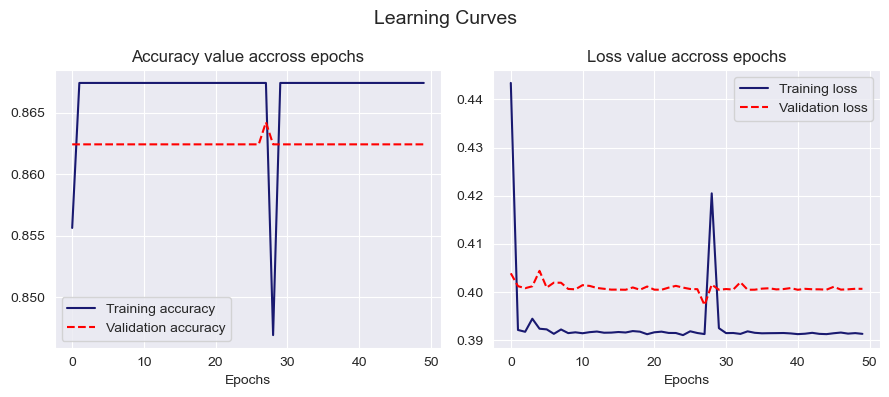

In [35]:
#Subplot
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Plotting accuracy on the first subplot
ax[0].plot(history_lstm.history["accuracy"], color="midnightblue",label="Training accuracy")
ax[0].plot(history_lstm.history["val_accuracy"], color="r",ls='--',label="Validation accuracy")
ax[0].set_title('Accuracy value accross epochs')
ax[0].legend()

# Plotting loss on the second subplot
ax[1].plot(history_lstm.history["loss"], color="midnightblue",label="Training loss")
ax[1].plot(history_lstm.history["val_loss"], ls='--', color="r",label="Validation loss")
ax[1].set_title("Loss value accross epochs")
ax[1].legend()

#Labelling axis x
for ax in ax:
    ax.set(xlabel='Epochs')

#Suptitle
fig.suptitle('Learning Curves', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [36]:
# Evaluate the model
val_loss_lstm, val_accuracy_lstm = model_lstm.evaluate(val_batch)
print(f"Validation Loss: {val_loss_lstm}")
print(f"Validation Accuracy: {val_accuracy_lstm}")

27/27 [==============================] - 1s 18ms/step - loss: 0.4007 - accuracy: 0.8624
Validation Loss: 0.40070441365242004
Validation Accuracy: 0.8624401688575745


This model is not as good as the first one, validation acuracy is stable and the validation loss is quite big.

In [37]:
# saving the model :
model_lstm.save("spam_detector_model_lstm.h5")

#### Third model : Simple RNN :

In [38]:
# Defining the model :
model_rnn = Sequential([
                  Embedding(vocab_size+1, embedding_dim, input_shape=[text.shape[1],], name="embedding"),
                  SimpleRNN(units=16, return_sequences=True),
                  SimpleRNN(units=8, return_sequences=False),
                  Dense(16, activation='relu'),
                  Dense(1, activation="sigmoid")
]);

In [39]:
# Compile the model
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
# Training the model :
history_rnn=model_rnn.fit(train_batch,
                    epochs=50,
                    validation_data=val_batch)

Epoch 1/50
61/61 [==============================] - 4s 29ms/step - loss: 0.4447 - accuracy: 0.8672 - val_loss: 0.4012 - val_accuracy: 0.8624
Epoch 2/50
61/61 [==============================] - 1s 23ms/step - loss: 0.3914 - accuracy: 0.8674 - val_loss: 0.4005 - val_accuracy: 0.8624
Epoch 3/50
61/61 [==============================] - 1s 22ms/step - loss: 0.3916 - accuracy: 0.8674 - val_loss: 0.4006 - val_accuracy: 0.8624
Epoch 4/50
61/61 [==============================] - 2s 26ms/step - loss: 0.3920 - accuracy: 0.8674 - val_loss: 0.4011 - val_accuracy: 0.8624
Epoch 5/50
61/61 [==============================] - 1s 23ms/step - loss: 0.3916 - accuracy: 0.8674 - val_loss: 0.4005 - val_accuracy: 0.8624
Epoch 6/50
61/61 [==============================] - 1s 23ms/step - loss: 0.3920 - accuracy: 0.8674 - val_loss: 0.4006 - val_accuracy: 0.8624
Epoch 7/50
61/61 [==============================] - 1s 22ms/step - loss: 0.3916 - accuracy: 0.8674 - val_loss: 0.4005 - val_accuracy: 0.8624
Epoch 8/50
61

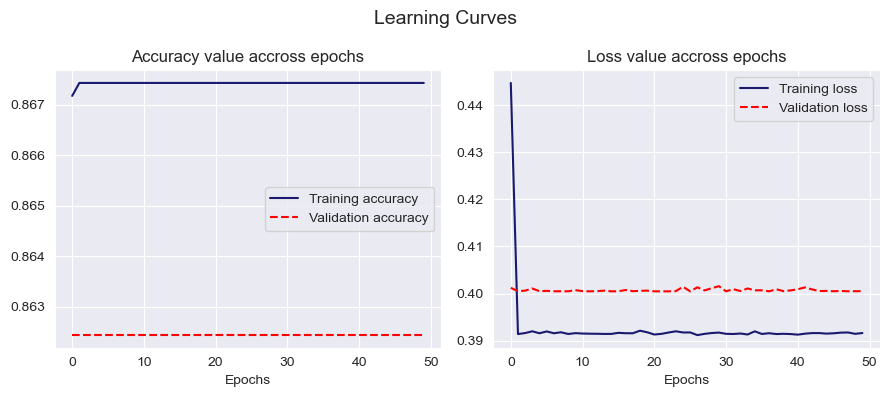

In [41]:
#Subplot
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Plotting accuracy on the first subplot
ax[0].plot(history_rnn.history["accuracy"], color="midnightblue",label="Training accuracy")
ax[0].plot(history_rnn.history["val_accuracy"], color="r",ls='--',label="Validation accuracy")
ax[0].set_title('Accuracy value accross epochs')
ax[0].legend()

# Plotting loss on the second subplot
ax[1].plot(history_rnn.history["loss"], color="midnightblue",label="Training loss")
ax[1].plot(history_rnn.history["val_loss"], ls='--', color="r",label="Validation loss")
ax[1].set_title("Loss value accross epochs")
ax[1].legend()

#Labelling axis x
for ax in ax:
    ax.set(xlabel='Epochs')

#Suptitle
fig.suptitle('Learning Curves', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [42]:
# Evaluate the model
val_loss_rnn, val_accuracy_rnn = model_rnn.evaluate(val_batch)
print(f"Validation Loss: {val_loss_rnn}")
print(f"Validation Accuracy: {val_accuracy_rnn}")

27/27 [==============================] - 0s 5ms/step - loss: 0.4005 - accuracy: 0.8624
Validation Loss: 0.40051817893981934
Validation Accuracy: 0.8624401688575745


This model is not so bad too, validation accuracy is quite good and kind of stable and the validation loss doesn't increase much after 10/15 epochs.

In [43]:
# saving the model :
model_rnn.save("spam_detector_model_rnn.h5")

#### Fourth model : GRU :

In [44]:
# Defining the model :
model_gru = Sequential([
                  Embedding(vocab_size+1, embedding_dim, input_shape=[text.shape[1],], name="embedding"),
                  GRU(units=64, return_sequences=True),
                  GRU(units=32, return_sequences=False),
                  Dense(16, activation='relu'),
                  Dense(1, activation="sigmoid")
]);

In [45]:
# Compile the model
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
# Training the model :
history_gru=model_gru.fit(train_batch,
                    epochs=50,
                    validation_data=val_batch)

Epoch 1/50
61/61 [==============================] - 8s 56ms/step - loss: 0.4423 - accuracy: 0.8674 - val_loss: 0.4076 - val_accuracy: 0.8624
Epoch 2/50
61/61 [==============================] - 3s 44ms/step - loss: 0.3940 - accuracy: 0.8674 - val_loss: 0.4007 - val_accuracy: 0.8624
Epoch 3/50
61/61 [==============================] - 3s 45ms/step - loss: 0.3931 - accuracy: 0.8674 - val_loss: 0.4006 - val_accuracy: 0.8624
Epoch 4/50
61/61 [==============================] - 3s 45ms/step - loss: 0.3936 - accuracy: 0.8674 - val_loss: 0.4012 - val_accuracy: 0.8624
Epoch 5/50
61/61 [==============================] - 3s 44ms/step - loss: 0.3922 - accuracy: 0.8674 - val_loss: 0.4042 - val_accuracy: 0.8624
Epoch 6/50
61/61 [==============================] - 3s 44ms/step - loss: 0.3928 - accuracy: 0.8674 - val_loss: 0.4011 - val_accuracy: 0.8624
Epoch 7/50
61/61 [==============================] - 3s 42ms/step - loss: 0.3922 - accuracy: 0.8674 - val_loss: 0.4007 - val_accuracy: 0.8624
Epoch 8/50
61

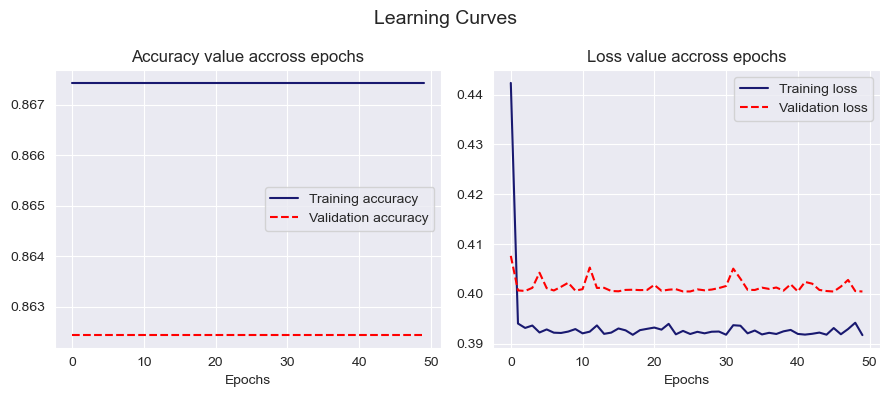

In [47]:
#Subplot
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Plotting accuracy on the first subplot
ax[0].plot(history_gru.history["accuracy"], color="midnightblue",label="Training accuracy")
ax[0].plot(history_gru.history["val_accuracy"], color="r",ls='--',label="Validation accuracy")
ax[0].set_title('Accuracy value accross epochs')
ax[0].legend()

# Plotting loss on the second subplot
ax[1].plot(history_gru.history["loss"], color="midnightblue",label="Training loss")
ax[1].plot(history_gru.history["val_loss"], ls='--', color="r",label="Validation loss")
ax[1].set_title("Loss value accross epochs")
ax[1].legend()

#Labelling axis x
for ax in ax:
    ax.set(xlabel='Epochs')

#Suptitle
fig.suptitle('Learning Curves', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [48]:
# Evaluate the model
val_loss_gru, val_accuracy_gru = model_gru.evaluate(val_batch)
print(f"Validation Loss: {val_loss_gru}")
print(f"Validation Accuracy: {val_accuracy_gru}")

27/27 [==============================] - 0s 14ms/step - loss: 0.4005 - accuracy: 0.8624
Validation Loss: 0.4004676043987274
Validation Accuracy: 0.8624401688575745


This model doesn't perform as good as the others. Validation accuracy is good and stable at 0,86... but the validation loss is a bit bigger with 0.38.

In [49]:
# saving the model :
model_gru.save("spam_detector_model_gru.h5")

#### Transfer learning :

In [50]:
# Train test split
X_train, X_val, y_train, y_val = train_test_split(df['text_clean'], df['Target_value'], test_size=0.3)

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [51]:
import tensorflow_hub as hub
import tensorflow_text

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-2-h-128-a-2/versions/2",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768]
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768]

out = tf.keras.layers.Dropout(0.2,name='dropout')(pooled_output)
out = tf.keras.layers.Dense(16,activation='relu')(out)
out = tf.keras.layers.Dense(1,activation='sigmoid',name='output')(out)

model_bert=tf.keras.Model(inputs=[text_input],outputs=[out])

model_bert.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_bert = model_bert.fit(train_batch,
                    epochs=50,
                    validation_data=val_batch)

INFO:absl:Using /var/folders/gh/5x8myy1s5j577m7hgyjfy8800000gn/T/tfhub_modules to cache modules.
INFO:absl:Fingerprint not found. Saved model loading will continue.
INFO:absl:path_and_singleprint metric could not be logged. Saved model loading will continue.
INFO:absl:Downloading TF-Hub Module 'https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-2-h-128-a-2/versions/2'.
INFO:absl:Downloaded https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-2-h-128-a-2/versions/2, Total size: 19.27MB
INFO:absl:Downloaded TF-Hub Module 'https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-2-h-128-a-2/versions/2'.
INFO:absl:Fingerprint not found. Saved model loading will continue.
INFO:absl:path_and_singleprint metric could not be logged. Saved model loading will continue.


Epoch 1/50
61/61 [==============================] - 26s 387ms/step - loss: 0.3882 - accuracy: 0.8518 - val_loss: 0.2448 - val_accuracy: 0.8864
Epoch 2/50
61/61 [==============================] - 23s 381ms/step - loss: 0.2263 - accuracy: 0.9059 - val_loss: 0.1694 - val_accuracy: 0.9342
Epoch 3/50
61/61 [==============================] - 23s 385ms/step - loss: 0.1784 - accuracy: 0.9287 - val_loss: 0.1416 - val_accuracy: 0.9462
Epoch 4/50
61/61 [==============================] - 21s 345ms/step - loss: 0.1665 - accuracy: 0.9374 - val_loss: 0.1307 - val_accuracy: 0.9545
Epoch 5/50
61/61 [==============================] - 22s 356ms/step - loss: 0.1502 - accuracy: 0.9438 - val_loss: 0.1154 - val_accuracy: 0.9599
Epoch 6/50
61/61 [==============================] - 21s 353ms/step - loss: 0.1443 - accuracy: 0.9487 - val_loss: 0.1074 - val_accuracy: 0.9641
Epoch 7/50
61/61 [==============================] - 20s 327ms/step - loss: 0.1347 - accuracy: 0.9528 - val_loss: 0.1020 - val_accuracy: 0.9653

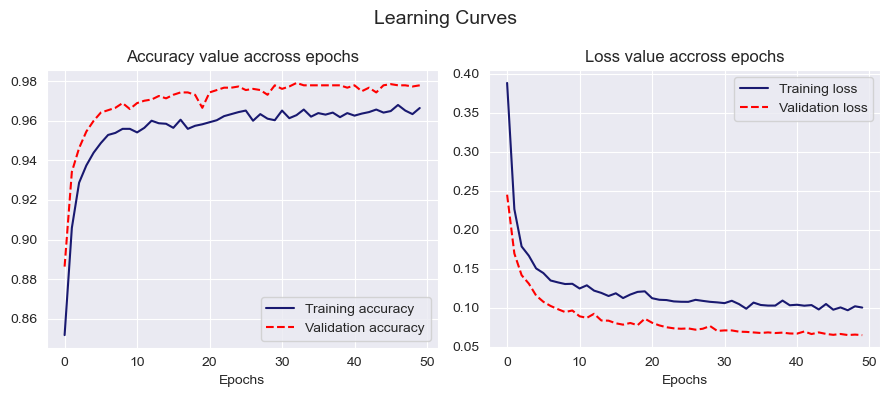

In [52]:
#Subplot
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Plotting accuracy on the first subplot
ax[0].plot(history_bert.history["accuracy"], color="midnightblue",label="Training accuracy")
ax[0].plot(history_bert.history["val_accuracy"], color="r",ls='--',label="Validation accuracy")
ax[0].set_title('Accuracy value accross epochs')
ax[0].legend()

# Plotting loss on the second subplot
ax[1].plot(history_bert.history["loss"], color="midnightblue",label="Training loss")
ax[1].plot(history_bert.history["val_loss"], ls='--', color="r",label="Validation loss")
ax[1].set_title("Loss value accross epochs")
ax[1].legend()

#Labelling axis x
for ax in ax:
    ax.set(xlabel='Epochs')

#Suptitle
fig.suptitle('Learning Curves', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [53]:
# Evaluate the model
val_loss_bert, val_accuracy_bert = model_bert.evaluate(val_batch)
print(f"Validation Loss: {val_loss_bert}")
print(f"Validation Accuracy: {val_accuracy_bert}")

27/27 [==============================] - 6s 224ms/step - loss: 0.0646 - accuracy: 0.9779
Validation Loss: 0.06461746990680695
Validation Accuracy: 0.9778708219528198


This model is really good. Validation accuracy hits 0.96 and is stable after 20 epochs and the gvalidation loss stays stable at 0.1 after 20 epochs and doesn' seem to increase.

In [54]:
# saving the model :
model_bert.save("spam_detector_model_bert.h5")

In [55]:
# Creating a DataFrame with the results
results = pd.DataFrame({'Simple Model': [val_accuracy,val_loss],
                        'LSTM model': [val_accuracy_lstm, val_loss_lstm],
                        'Simple RNN model': [val_accuracy_rnn, val_loss_rnn],
                        'GRU model': [val_accuracy_gru, val_loss_gru],
                        'Bert model':[val_accuracy_bert,val_loss_bert]},
                                      index=['Accuracy','Loss'])

results.T

,Accuracy,Loss
Simple Model,0.980263,0.086753
LSTM model,0.862440,0.400704
Simple RNN model,0.862440,0.400518
GRU model,0.862440,0.400468
Bert model,0.977871,0.064617


# Conclusion :

* The best results are the results we got from the first model which is a simple model from scratch.
* We got some good results with the BERT model too which is quite logic since the model was pretrained multiples times before and this model alows us to avoind text cleaning but the time computing was quite long for this one.
* We can also try to change "maxwords"and "maxlen" to improve results and time computing.